# YouTube on Android

The goal of this experiment is to run Youtube videos on a Pixel device running Android and collect results.

In [1]:
from conf import LisaLogging
import logging
LisaLogging.setup(level=logging.DEBUG)

2017-08-14 17:33:57,948 INFO    : root         : Using LISA logging configuration:
2017-08-14 17:33:57,950 INFO    : root         :   /media/build/workspace/lisa-github/logging.conf


In [2]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import System, Screen, Workload

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

import pandas as pd
import sqlite3

Populating the interactive namespace from numpy and matplotlib


## Support Functions

This function helps us run our experiments:

In [3]:
def experiment():
    
    # Configure governor
    target.cpufreq.set_all_governors('sched')

    # Get workload
    wload = Workload(te).getInstance(te, 'YouTube')
    
    # Run Youtube workload
    wload.run(te.res_dir, 'https://youtu.be/XSGBVzeBUbk?t=45s',
              video_duration_s=5, collect='systrace')

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

## Test environment setup
For more details on this please check out **examples/utils/testenv_example.ipynb**.

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [4]:
# Setup target configuration
my_conf = {
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/media/build/workspace/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : 'baylibre-acme.local',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
        }
    },


    # Folder where all the results will be collected
    "results_dir" : "Youtube_example",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq',       # enable CPUFreq support
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_capacity",
            "cpu_frequency",
             
            # Add here the events you wanna enable by hand
            "sched_energy_diff",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset' ],
}

In [6]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

2017-08-14 17:34:51,186 INFO    : TestEnv      : Using base path: /media/build/workspace/lisa-github
2017-08-14 17:34:51,188 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-08-14 17:34:51,189 INFO    : TestEnv      : External tools using:
2017-08-14 17:34:51,191 INFO    : TestEnv      :    ANDROID_HOME: /media/build/workspace/android-sdk
2017-08-14 17:34:51,192 INFO    : TestEnv      :    CATAPULT_HOME: /media/build/workspace/lisa-github/tools/catapult
2017-08-14 17:34:51,193 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2017-08-14 17:34:51,194 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2017-08-14 17:34:51,197 INFO    : TestEnv      : Connection settings:
2017-08-14 17:34:51,197 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}
2017-08-14 17:34:51,985 INFO    : TestEnv      : Initializing target workdir:
2017-08-14 17:34:51,989 INFO    : TestEnv      :    /data/local/tmp/devlib-target
2017-08

In [18]:
# ADB ROOT is requried for systrace to be able to get the generated trace from the target
!adb root

adbd is already running as root


## Workloads execution

This is done using the **experiment** helper function defined above which is configured to run a **Youtube** experiment.

In [7]:
# Configure governor
target.cpufreq.set_all_governors('sched')

# Get workload
wload = Workload(te).getInstance(te, 'YouTube')
    
# Run Youtube workload
wload.run(te.res_dir, 'https://youtu.be/XSGBVzeBUbk?t=45s',
            video_duration_s=5, collect='systrace')

2017-08-14 17:32:23,886 INFO    : Workload     : Packages:
['com.android.cts.priv.ctsshim', 'com.android.providers.telephony', 'com.android.providers.calendar', 'com.android.providers.media', 'com.android.wallpapercropper', 'com.android.launcher', 'com.antutu.ABenchMark', 'com.android.documentsui', 'com.android.externalstorage', 'com.android.htmlviewer', 'com.android.quicksearchbox', 'com.android.mms.service', 'com.android.providers.downloads', 'com.primatelabs.geekbench', 'com.android.defcontainer', 'com.android.providers.downloads.ui', 'com.android.pacprocessor', 'com.android.certinstaller', 'android', 'com.android.contacts', 'com.android.camera2', 'com.android.egg', 'com.android.mtp', 'com.android.backupconfirm', 'com.android.provision', 'com.android.statementservice', 'com.android.calendar', 'com.android.providers.settings', 'com.android.sharedstoragebackup', 'com.android.printspooler', 'com.android.dreams.basic', 'com.android.webview', 'com.android.inputdevices', 'com.android.bips

In [7]:
# Intialize Workloads for this test environment
results = experiment()

2017-08-14 17:35:09,075 INFO    : Workload     : Packages:
['com.android.cts.priv.ctsshim', 'com.android.providers.telephony', 'com.android.providers.calendar', 'com.android.providers.media', 'com.android.wallpapercropper', 'com.android.launcher', 'com.antutu.ABenchMark', 'com.android.documentsui', 'com.android.externalstorage', 'com.android.htmlviewer', 'com.android.quicksearchbox', 'com.android.mms.service', 'com.android.providers.downloads', 'com.primatelabs.geekbench', 'com.android.defcontainer', 'com.android.providers.downloads.ui', 'com.android.pacprocessor', 'com.android.certinstaller', 'android', 'com.android.contacts', 'com.android.camera2', 'com.android.egg', 'com.android.mtp', 'com.android.backupconfirm', 'com.android.provision', 'com.android.statementservice', 'com.android.calendar', 'com.android.providers.settings', 'com.android.sharedstoragebackup', 'com.android.printspooler', 'com.android.dreams.basic', 'com.android.webview', 'com.android.inputdevices', 'com.android.bips

## Benchmarks results

In [8]:
# Benchmark statistics
db_file = os.path.join(te.res_dir, "framestats.txt")
!sed '/Stats since/,/99th/!d;/99th/q' {db_file}

# For all results:
# !cat {results['db_file']}

Stats since: 8341716500289ns
Total frames rendered: 737
Janky frames: 285 (38.67%)
50th percentile: 14ms
90th percentile: 27ms
95th percentile: 31ms
99th percentile: 46ms


## Traces visualisation

For more information on this please check **examples/trace_analysis/TraceAnalysis_TasksLatencies.ipynb**.

In [9]:
# Parse all traces
platform_file = os.path.join(te.res_dir, 'platform.json')
with open(platform_file, 'r') as fh:
    platform = json.load(fh)
trace_file = os.path.join(te.res_dir, 'trace.html')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

trappy.plotter.plot_trace(trace.ftrace)

2017-08-14 17:35:41,489 DEBUG   : Trace        : Loading [sched] events from trace in [/media/build/workspace/lisa-github/results/Youtube_example/trace.html]...
2017-08-14 17:35:41,491 DEBUG   : Trace        : Parsing events: ['sched_switch', 'sched_wakeup', 'sched_wakeup_new', 'sched_overutilized', 'sched_load_avg_cpu', 'sched_load_avg_task', 'cpu_capacity', 'cpu_frequency', 'sched_energy_diff', 'cpu_frequency_devlib']
2017-08-14 17:35:41,496 DEBUG   : Trace        : Parsing SysTrace format...
2017-08-14 17:35:44,780 DEBUG   : Trace        : Events found on trace:
2017-08-14 17:35:44,782 DEBUG   : Trace        :  - cpu_frequency
2017-08-14 17:35:44,784 DEBUG   : Trace        :  - tracing_mark_write
2017-08-14 17:35:44,786 DEBUG   : Trace        :  - cpu_idle
2017-08-14 17:35:44,788 DEBUG   : Trace        :  - sched_switch
2017-08-14 17:35:44,790 DEBUG   : Trace        :  - sched_wakeup
2017-08-14 17:35:44,801 DEBUG   : Trace        : Collected events spans a 4.135 [s] time interval
20

2017-08-14 17:36:05,150 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-08-14 17:36:05,154 WARNING : Analysis     : NO LITTLE CPUs frequency events to plot
2017-08-14 17:36:05,157 WARNING : Analysis     : Event [sched_overutilized] not found, plot DISABLED!
2017-08-14 17:36:05,521 INFO    : Analysis     : LITTLE cluster average frequency: 0.000 GHz
2017-08-14 17:36:05,523 INFO    : Analysis     : big    cluster average frequency: 1.405 GHz
2017-08-14 17:36:05,527 INFO    : root         : Plotting cluster frequencies for [sched]...


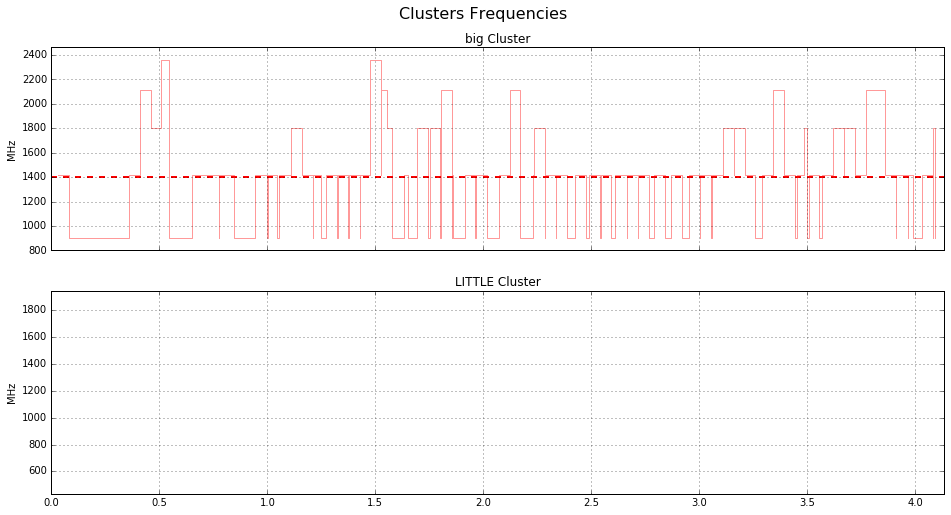

In [10]:
try:
    trace.analysis.frequency.plotClusterFrequencies();
    logging.info('Plotting cluster frequencies for [sched]...')
except: pass

In [11]:
df = trace.data_frame.trace_event('sched_energy_diff')

In [12]:
df.head()

""
